In [1]:
from scipy.stats import dirichlet
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import seaborn as sns
from scipy.stats import entropy
from scipy import stats
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
out_stem = 'K562_rep6'
basedir = Path('/home/hsher/scratch/ABC_2rep/')
from plot_params import *

# fitted parameters and outputs
data = pd.read_csv(basedir/f'DMM/{out_stem}.mixture_weight.tsv', sep = '\t', index_col = 0) # basedir/f'DMM/{out_stem}.mixture_weight.tsv'
data.set_index('Row.names', inplace = True)

mixture_weight_only = data.loc[:, data.columns.str.startswith('V')]
mixture_weight_only.columns
data['cluster']=mixture_weight_only.idxmax(axis = 1)

weights = pd.read_csv(basedir/f'DMM/{out_stem}.weights.tsv', sep = '\t', index_col = 0)
weights.index = [f'V{i}' for i in weights.index]

model_alphas = pd.read_csv(basedir/f'DMM/{out_stem}.alpha.tsv', sep = '\t',
                      index_col = 0) # RBP by components, B * K
model_alphas.columns = [i.replace('X', 'V') for i in model_alphas.columns]
model_mean = model_alphas.div(model_alphas.sum(axis = 0), axis = 1)
model_var = model_alphas.apply(lambda column: dirichlet(column).var(), axis = 0)
model_std = np.sqrt(model_var)

# raw_counts to calculate bayes factor
raw_counts = pd.read_csv(basedir /f'counts/genome/megatables/{out_stem}.tsv.gz', sep = '\t')
raw_counts.index = raw_counts.index+1
raw_counts = raw_counts.loc[data.index] # filter for those that has been modelled (passing the total_read_threshold)

# find total mapped reads as the null
nread_per_window = raw_counts.sum(axis = 1)
mapped_reads = raw_counts.sum(axis = 0)
mapped_reads_fraction = mapped_reads.div(mapped_reads.sum())
print('========Fraction mapped reads: \n ========',mapped_reads_fraction.sort_values())

========Fraction mapped reads: 
 ======== K562_rep6.PUM2       0.012186
K562_rep6.EIF3G      0.021911
K562_rep6.ZC3H11A    0.046279
K562_rep6.DDX3       0.052660
K562_rep6.LIN28B     0.061447
K562_rep6.SF3B4      0.082962
K562_rep6.IGF2BP2    0.101432
K562_rep6.PRPF8      0.123342
K562_rep6.RBFOX2     0.125082
K562_rep6.FAM120A    0.372698
dtype: float64


In [2]:
# annotations
anno = pd.read_csv(basedir/f'DMM/{out_stem}.cluster_annotation_binary.csv',
                          index_col = 0) # RBP by components, B * K

In [3]:
import sys
sys.path.append('/home/hsher/projects/oligoCLIP/scripts/')
from analyze_DMM import DMM_bayes_factor

In [4]:
rbp = f'{out_stem}.PUM2'
bound_components = anno[rbp][anno[rbp]].index
DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, raw_counts.iloc[:10])['logLR']

2023-11-10 11:30:33.676955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 11:30:37.836253: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Row.names
1          1.032840
10        -0.357044
100013    -0.243893
100014    -0.277274
100015    -0.341485
1000441   -0.226858
1001007   -0.243893
1001009   -0.309787
1001014   -0.277274
1001139    0.598447
Name: logLR, dtype: float64

In [5]:
from pybedtools import BedTool
indir_kd = Path('/home/hsher/scratch/encode_kd/output/rMATs')
def load_region_dict_from_encode_kd(event_type, cell_line, rbp):
    regions_dict = {}
    root_path = indir_kd / f'{rbp}_{cell_line}' /  'regions' / event_type 
    
    
    files = root_path.glob('*/*.bed')
    
    for f in files:
        group = f.parent.name
        region = f.name.split('.')[0]
        regions_dict[group, region] = BedTool(f)
    return regions_dict
        

In [6]:
count_dir = Path('/home/hsher/scratch/count_A3SS')
long_ss3_counts = pd.read_csv(count_dir/f'A5SS_long_3intron/counts/genome/megatables/{out_stem}.tsv.gz',
                             sep = '\t')
short_ss3_counts = pd.read_csv(count_dir/f'A5SS_exon_diff_interval/counts/genome/megatables/{out_stem}.tsv.gz',
                             sep = '\t')

In [7]:
long_bed = pd.read_csv('/home/hsher/scratch/A5SS_long_3intron.bed', sep = '\t',
                       names = ['chrom', 'start', 'end', 'name', 'score', 'strand']
                      )
short_bed = pd.read_csv('/home/hsher/scratch/A5SS_exon_diff_interval.bed', sep = '\t',
                       names = ['chrom', 'start', 'end', 'name', 'score', 'strand']
                      )

In [8]:
short_bed['len'] = short_bed['end']-short_bed['start']

In [9]:
long_ss3_counts.index = long_bed['name']
short_ss3_counts.index = short_bed['name']

In [10]:
common_index = list(set(long_ss3_counts.loc[long_ss3_counts.sum(axis = 1)>5].index).intersection(
    set(short_ss3_counts.loc[short_ss3_counts.sum(axis = 1)>5].index)
).intersection(short_bed.loc[short_bed['len']>50, 'name'])
                   )

In [11]:
rbp = f'{out_stem}.SF3B4'
bound_components = anno[rbp][anno[rbp]].index
short_LR = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, short_ss3_counts.loc[common_index])['logLR']
long_LR = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, long_ss3_counts.loc[common_index])['logLR']


In [12]:
rbp = f'{out_stem}.PRPF8'
bound_components = anno[rbp][anno[rbp]].index
short_LR_prpf8 = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, short_ss3_counts.loc[common_index])['logLR']
long_LR_prpf8 = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, long_ss3_counts.loc[common_index])['logLR']


In [13]:
rbp = f'{out_stem}.RBFOX2'
bound_components = anno[rbp][anno[rbp]].index
short_LR_rbfox2 = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, short_ss3_counts.loc[common_index])['logLR']
long_LR_rbfox2 = DMM_bayes_factor(model_alphas, weights, [rbp], bound_components, long_ss3_counts.loc[common_index])['logLR']


In [14]:
rmats_dir = Path('/projects/ps-yeolab5/encode/rnaseq/alt_splicing_hg38')
# ids = ['ENCSR336DFS'
# 'ENCSR081XRA',
# 'ENCSR137HKS',
# 'ENCSR952RRH'
# ]
# rbps = ['RBFOX2', 'SF3B4', 'PRPF8', 'IGF2BP2']
rnaseq_index=pd.read_csv('/home/hsher/projects/ClipNet/KD_Rnaseq.csv')
rnaseq_index['RBP']=rnaseq_index['Experiment target'].str.split('-', expand = True)[0]
rnaseq_index['comparison']=rnaseq_index['RBP']+'_'+rnaseq_index['Biosample term name']

a3ss_rmats = pd.read_csv(rmats_dir / rnaseq_index.loc[rnaseq_index['comparison']=='PRPF8_K562', 
                                                      'Experiment accession'].iloc[0] / 'MATS_output'/
                         f'A5SS.MATS.JunctionCountOnly.txt',
            sep = '\t')

In [15]:
a3ss_rmats = a3ss_rmats.loc[a3ss_rmats['ID'].isin(common_index)]
a3ss_rmats['long_ss5_logLR'] = a3ss_rmats['ID'].map(long_LR)
a3ss_rmats['short_ss5_logLR'] = a3ss_rmats['ID'].map(short_LR)
a3ss_rmats['long_ss5_logLR_prpf8'] = a3ss_rmats['ID'].map(long_LR_prpf8)
a3ss_rmats['short_ss5_logLR_prpf8'] = a3ss_rmats['ID'].map(short_LR_prpf8)
a3ss_rmats['long_cov']=a3ss_rmats['ID'].map(long_ss3_counts.sum(axis = 1))
a3ss_rmats['short_cov']=a3ss_rmats['ID'].map(short_ss3_counts.sum(axis = 1))

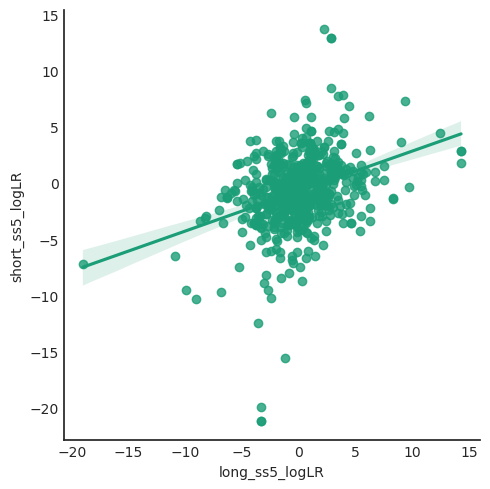

In [16]:
sns.lmplot(data = a3ss_rmats, 
           x = 'long_ss5_logLR', y = 'short_ss5_logLR')


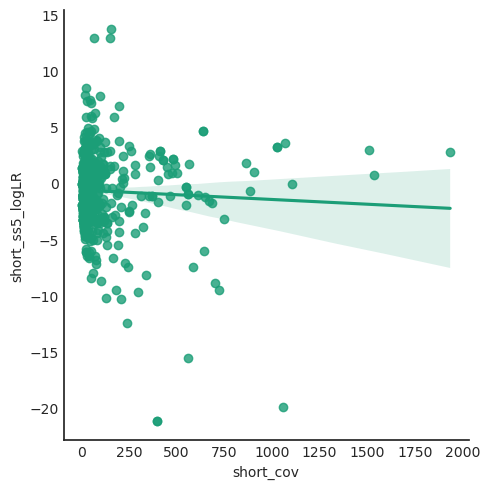

In [17]:
sns.lmplot(data = a3ss_rmats, 
           x = 'short_cov', y = 'short_ss5_logLR')


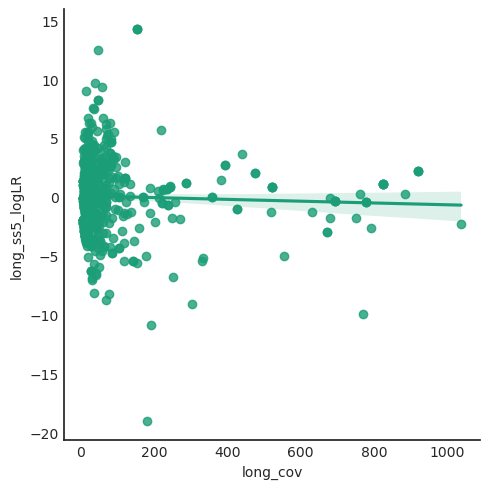

In [18]:
sns.lmplot(data = a3ss_rmats, 
           x = 'long_cov', y = 'long_ss5_logLR')


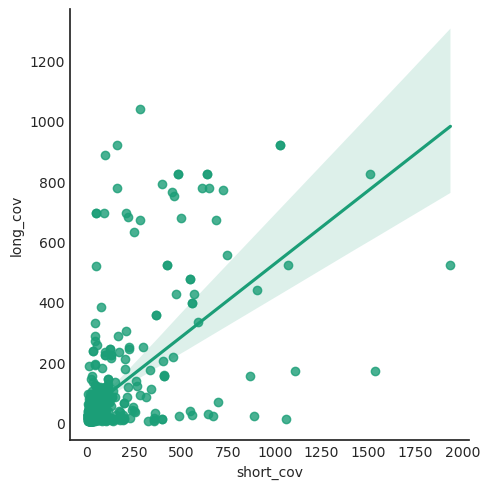

In [19]:
sns.lmplot(data = a3ss_rmats, 
           x = 'short_cov', y = 'long_cov')


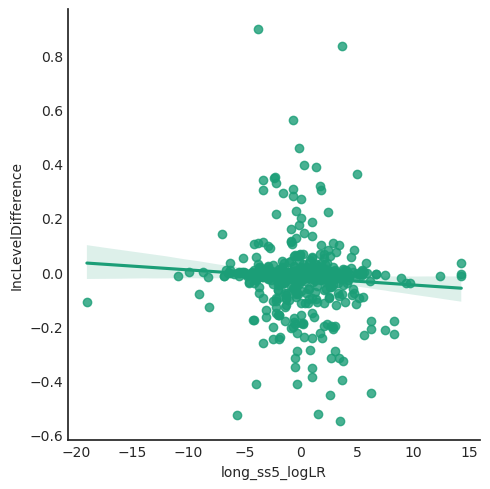

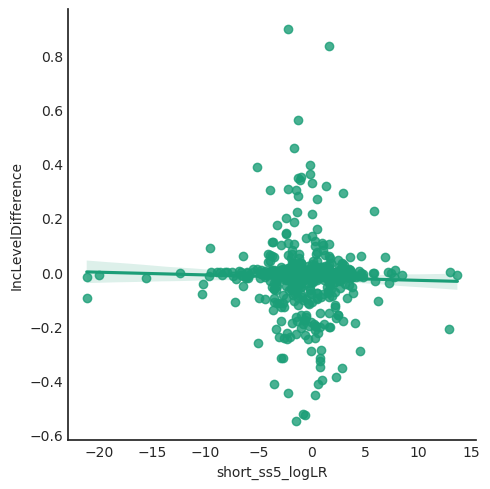

In [20]:
sns.lmplot(a3ss_rmats, x = 'long_ss5_logLR', y = 'IncLevelDifference')
sns.lmplot(a3ss_rmats, x = 'short_ss5_logLR', y = 'IncLevelDifference')

Text(0.5, 0, 'long binding score - short binding score')

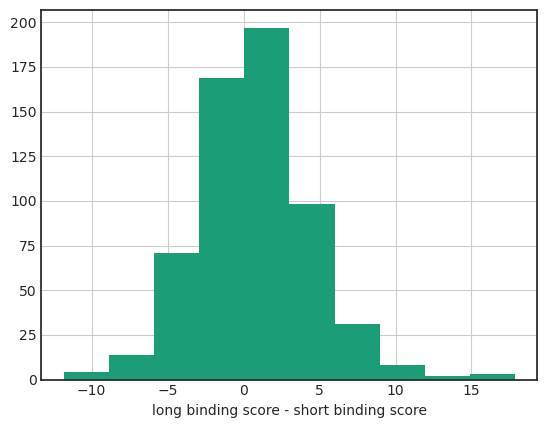

In [21]:
a3ss_rmats['delta logLR (long - short)']=(a3ss_rmats['long_ss5_logLR']-a3ss_rmats['short_ss5_logLR'])
a3ss_rmats['delta logLR (long - short)'].hist()
plt.xlabel('long binding score - short binding score')

In [22]:
a3ss_rmats.loc[(a3ss_rmats['FDR']<0.2)&(a3ss_rmats['IncLevelDifference']<-0.05), 'group']='exclusion(KD use short)'
a3ss_rmats.loc[(a3ss_rmats['FDR']<0.2)&(a3ss_rmats['IncLevelDifference']>0.05), 'group']='inclusion(KD use long)'
a3ss_rmats['group'] = a3ss_rmats['group'].fillna('ctrl')

In [23]:
def comma_delim_mean(string):
    return np.mean([float(s) for s in string.split(',') if s!='NA'])


In [24]:
a3ss_rmats['WT_inclusion_level']=a3ss_rmats['IncLevel2'].apply(comma_delim_mean)
a3ss_rmats['KD_inclusion_level']=a3ss_rmats['IncLevel1'].apply(comma_delim_mean)

In [25]:
well_cov = a3ss_rmats.loc[(a3ss_rmats['SJC_SAMPLE_2'].apply(comma_delim_mean)>10)&
                                (a3ss_rmats['IJC_SAMPLE_2'].apply(comma_delim_mean)>10)
                                ]

PearsonRResult(statistic=-0.28632437582803927, pvalue=0.029334912254851474)


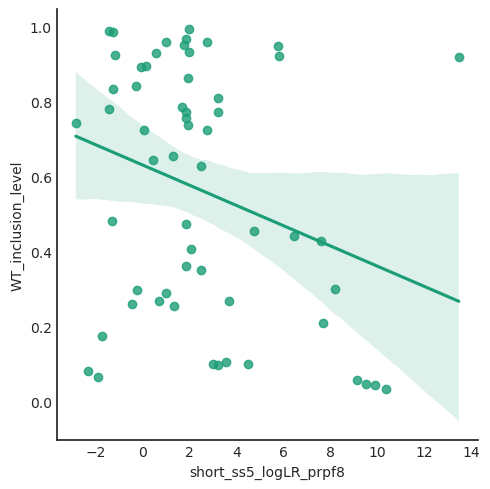

In [26]:
sns.lmplot(data = well_cov,x = 'short_ss5_logLR_prpf8', y = 'WT_inclusion_level')
print(pearsonr(well_cov['short_ss5_logLR_prpf8'], well_cov['WT_inclusion_level']))

plt.savefig(figdir/'A5SS_PRPF8_short.pdf')

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

IJC_wt = a3ss_rmats['IJC_SAMPLE_1'].str.split(',', expand = True).astype(int)
IJC_wt.columns = ['IJC_WT_rep1','IJC_WT_rep2']
SJC_wt = a3ss_rmats['SJC_SAMPLE_1'].str.split(',', expand = True).astype(int)
SJC_wt.columns = ['SJC_WT_rep1','SJC_WT_rep2']
a3ss_count_df = pd.concat([IJC_wt, SJC_wt, a3ss_rmats[['long_ss5_logLR_prpf8','short_ss5_logLR_prpf8']]], axis = 1).dropna()

r1 = a3ss_count_df[['IJC_WT_rep1', 'SJC_WT_rep1','long_ss5_logLR_prpf8','short_ss5_logLR_prpf8']]
r2 = a3ss_count_df[['IJC_WT_rep2', 'SJC_WT_rep2','long_ss5_logLR_prpf8','short_ss5_logLR_prpf8']]
r2.columns = r1.columns
a3ss_count_df_rep_ravel = pd.concat([r1, r2], axis = 0)
a3ss_count_df_rep_ravel.index = np.arange(a3ss_count_df_rep_ravel.shape[0])
a3ss_count_df_rep_ravel.columns = ['IJC', 'SJC', 'long_ss5_logLR','short_ss5_logLR']
binom = sm.families.Binomial()
lrTest = smf.glm('IJC + SJC ~ long_ss5_logLR + short_ss5_logLR', 
                 a3ss_count_df_rep_ravel, family=binom).fit()
print(lrTest.summary())
# https://timeseriesreasoning.com/contents/binomial-regression-model/


                 Generalized Linear Model Regression Results                  
Dep. Variable:         ['IJC', 'SJC']   No. Observations:                 1194
Model:                            GLM   Df Residuals:                     1191
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63927.
Date:                Fri, 10 Nov 2023   Deviance:                   1.2493e+05
Time:                        11:32:36   Pearson chi2:                 3.35e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.6790      0.009    4

In [28]:
a3ss_rmats[['long_ss5_logLR','short_ss5_logLR']].describe()

,long_ss5_logLR,short_ss5_logLR
count,597.000000,597.000000
mean,0.018537,-0.713896
std,3.160470,3.388250
min,-19.022994,-21.193266
25%,-1.751627,-2.359776
50%,-0.022722,-0.633914
75%,1.713839,1.069854
max,14.282485,13.695931


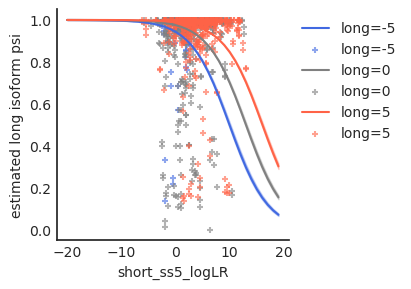

In [29]:
p_raw=(a3ss_count_df_rep_ravel['IJC']/(a3ss_count_df_rep_ravel['IJC']+a3ss_count_df_rep_ravel['SJC']))
p_raw.name ='raw IJC usage'
stat = pd.concat([lrTest.fittedvalues, a3ss_count_df_rep_ravel, p_raw], axis = 1)

f, ax = plt.subplots(figsize = (3,3))

for long_ss_value, color in zip([-5, 0, 5], ['royalblue', 'grey',
                                                     'tomato']):
    values = pd.DataFrame(np.stack([np.ones(40)*long_ss_value, np.arange(-20,20)]).T,
                 columns = ['long_ss5_logLR','short_ss5_logLR']
                )
    yhat = lrTest.predict(values)
    yhat.index = values['short_ss5_logLR']
    yhat.plot(ax = ax, label = f'long={long_ss_value}', color = color)
    
    ci = lrTest.get_prediction(values).summary_frame(alpha=0.05)
    ci.index = values['short_ss5_logLR']
    ax.fill_between(x = ci.index, y1 = ci['mean_ci_lower'], y2 = ci['mean_ci_upper'],
                    color = color, alpha = 0.3)
    
    stat.loc[(stat['long_ss5_logLR']>long_ss_value-2.5)&
             (stat['long_ss5_logLR']<long_ss_value+2.5)].plot.scatter(
        x = 'short_ss5_logLR', y = 'raw IJC usage', marker = '+',label = f'long={long_ss_value}', 
        ax = ax, color = color, alpha = 0.6)
ax.set_xlabel('short_ss5_logLR')
ax.set_ylabel('estimated long isoform psi')
ax.legend(bbox_to_anchor = (1,1))
sns.despine()
plt.savefig(figdir/'binom_a5ss_fit.pdf')

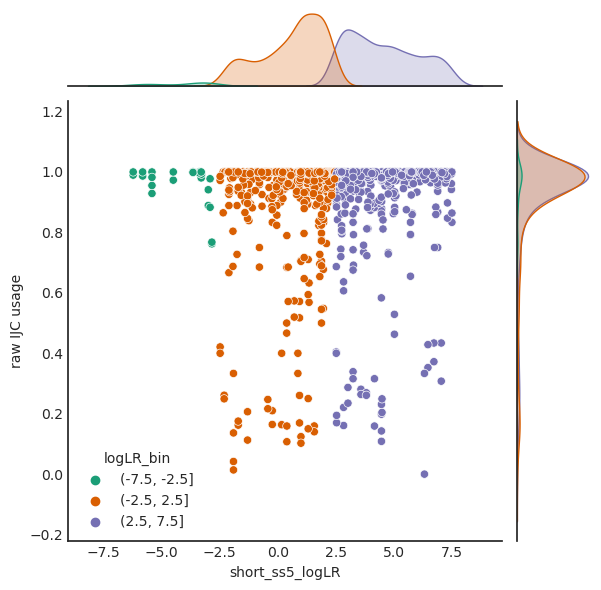

In [30]:
stat['logLR_bin']=pd.cut(stat['short_ss5_logLR'], bins = (-7.5, -2.5, 2.5, 7.5))
g = sns.jointplot(data=stat, x="short_ss5_logLR", y='raw IJC usage', hue="logLR_bin")

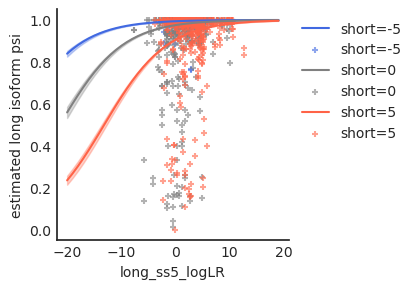

In [31]:
f, ax = plt.subplots(figsize = (3,3))

for short_ss_value, color in zip([-5, 0, 5], ['royalblue', 'grey',
                                                     'tomato']):
    values = pd.DataFrame(np.stack([np.arange(-20,20), np.ones(40)*short_ss_value]).T,
                 columns = ['long_ss5_logLR','short_ss5_logLR']
                )
    yhat = lrTest.predict(values)
    yhat.index = values['long_ss5_logLR']
    yhat.plot(ax = ax, label = f'short={short_ss_value}', color = color)
    
    ci = lrTest.get_prediction(values).summary_frame(alpha=0.05)
    ci.index = values['long_ss5_logLR']
    ax.fill_between(x = ci.index, y1 = ci['mean_ci_lower'], y2 = ci['mean_ci_upper'],
                    color = color, alpha = 0.3)
    
    stat.loc[(stat['short_ss5_logLR']>short_ss_value-2.5)&
             (stat['short_ss5_logLR']<short_ss_value+2.5)].plot.scatter(
        x = 'long_ss5_logLR', y = 'raw IJC usage', marker = '+',label = f'short={short_ss_value}', 
        ax = ax, color = color, alpha = 0.6)
ax.set_xlabel('long_ss5_logLR')
ax.set_ylabel('estimated long isoform psi')
ax.legend(bbox_to_anchor = (1,1))
sns.despine()
plt.savefig(figdir/'binom_a5ss_fit_long.pdf')

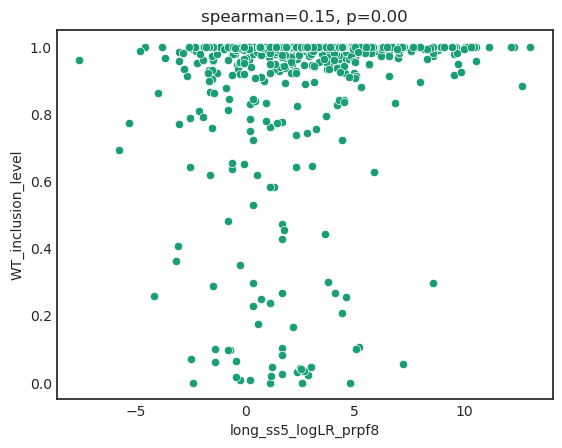

In [32]:
from scipy.stats import spearmanr
sns.scatterplot(data = a3ss_rmats.dropna(),x = 'long_ss5_logLR_prpf8', y = 'WT_inclusion_level')
r,p=spearmanr(a3ss_rmats.dropna()['long_ss5_logLR_prpf8'], a3ss_rmats.dropna()['WT_inclusion_level'])
plt.title(f'spearman={r:.2f}, p={p:.2f}')
plt.savefig(figdir/'A5SS_PRPF8_long.pdf')

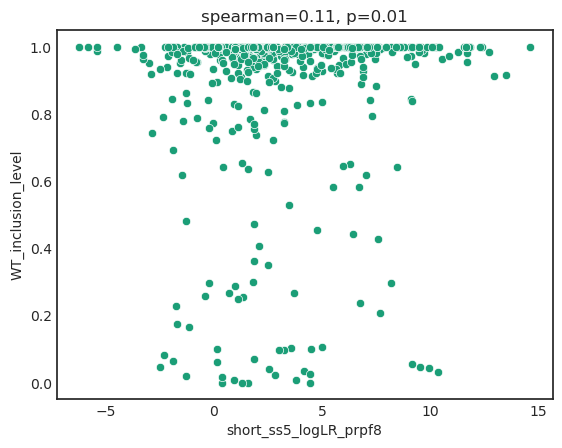

In [33]:
from scipy.stats import spearmanr
sns.scatterplot(data = a3ss_rmats.dropna(),x = 'short_ss5_logLR_prpf8', y = 'WT_inclusion_level')
r,p=spearmanr(a3ss_rmats.dropna()['short_ss5_logLR_prpf8'], a3ss_rmats.dropna()['WT_inclusion_level'])
plt.title(f'spearman={r:.2f}, p={p:.2f}')
plt.savefig(figdir/'A5SS_PRPF8_long.pdf')